Connected to biopipe (Python 3.8.13)

In [1]:
import pandas as pd
import os
visit = "first"
direction = "hypo"
path_annotatr_result = f"/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_{visit}Visit/annotation/methyl_{direction}_severe_mild_{visit}Visit_annotatr.tsv"
table_annot = pd.read_csv(path_annotatr_result, sep = '\t')
table_annot["position"] = table_annot.apply(lambda x : f"{x['seqnames']}_{x['start']}_{x['end']}", axis = 1)

In [2]:
def get_cpg_info(table):
    table_cpg = table[list(map(lambda x : "cpg" in x, table["annot.type"]))]
    if table_cpg.shape[0] == 0:
        cpg_info = "unrecog"
    else:
        cpg_info = table_cpg["annot.type"].to_list()[0].split('_')[-1]
    if cpg_info == "inter":
        cpg_info = "OpenSea"
    elif cpg_info == "shores":
        cpg_info = "CpG Shore"
    elif cpg_info == "shelves":
        cpg_info = "CpG Shelf"
    elif cpg_info == "islands":
        cpg_info = "CpG Island"
    elif cpg_info == "unrecog":
        cpg_info = "Unknown"
    else:
        raise Exception(f"Undefined CpG type : {cpg_info}")
    return cpg_info

def is_enhancer(table):
    table_enhanc = table[table["annot.type"] == "hg38_enhancers_fantom"]
    is_enhanc = table_enhanc.shape[0] > 0
    return is_enhanc

In [3]:
def organize_table_by_chr(table_chr):
    table_organized = pd.DataFrame(columns = ["chr", "start", "end", "CpGs", "Gene_Symbol", "Gene_Attrib", "Is_Enhancer", "PosName"])

    name_conv = {
        "1to5kb" : "Far_Promoter",
        "promoter" : "Promoter",
        "3UTR" : "3'UTR",
        "5UTR" : "5'UTR",
        "exon" : "Exon",
        "intron" : "Intron",
        "intronexonboundary" : "IntronExonBoundary"
    }
    list_chr = list()
    list_start = list()
    list_end = list()
    list_cpg = list()
    list_symb = list()
    list_attr = list()
    list_enh = list()
    list_pos = list()

    ind_table_org = 0
    for pos in table_chr["position"].unique():
        chrname, start, end = pos.split('_')
        table_part = table_chr.loc[pos, :].copy()
        if isinstance(table_part, pd.DataFrame):
            table_part = table_part.reset_index(drop = True)
        else:
            table_part = pd.DataFrame(table_part).T.reset_index(drop = True)
        cpg_type = get_cpg_info(table_part)
        is_enhanc = is_enhancer(table_part)
        table_gene = table_part.dropna(subset = ["annot.gene_id", "annot.tx_id"], how = "all")
        list_annot_id = list(map(lambda x : x.split(':')[0], table_gene["annot.id"]))
        list_gene_symbol = table_gene["annot.symbol"].to_list()
        list_gene_tx = table_gene["annot.tx_id"].to_list()
        list_gene_name = list(map(lambda x, y: x if not pd.isna(x) else y, list_gene_symbol, list_gene_tx))
        list_gene_annot = list(map(lambda x,y : f"{x}::{name_conv[y]}", list_gene_name, list_annot_id))
        if len(list_gene_annot) == 0:
            gene_symbol = "None"
            annot_id = "Intergenic"
            list_chr.append(chrname)
            list_start.append(start)
            list_end.append(end)
            list_cpg.append(cpg_type)
            list_symb.append(gene_symbol)
            list_attr.append(annot_id)
            list_enh.append(is_enhanc)
            list_pos.append(pos)
            # list_row = [chrname, start, end, cpg_type, gene_symbol, annot_id, is_enhanc, pos]
            # table_organized.loc[ind_table_org, :] = list_row
            # ind_table_org += 1
        else:
            for gene_annot in set(list_gene_annot):
                gene_symbol, annot_id = gene_annot.split("::")
                
                list_chr.append(chrname)
                list_start.append(start)
                list_end.append(end)
                list_cpg.append(cpg_type)
                list_symb.append(gene_symbol)
                list_attr.append(annot_id)
                list_enh.append(is_enhanc)
                list_pos.append(pos)
                # list_row = [chrname, start, end, cpg_type, gene_symbol, annot_id, is_enhanc, pos]
                # table_organized.loc[ind_table_org, :] = list_row
                # ind_table_org += 1
    table_organized["chr"] = list_chr
    table_organized["start"] = list_start
    table_organized["end"] = list_end
    table_organized["CpGs"] = list_cpg
    table_organized["Gene_Symbol"] = list_symb
    table_organized["Gene_Attrib"] = list_attr
    table_organized["Is_Enhancer"] = list_enh
    table_organized["PosName"] = list_pos

    # table_organized.to_csv(f"/BiO/Research/Project2/CardiomicsMethylome/Cardiomics_10_fold_cross_validation_DMP.20230302/Results/MethylCpGTable/Cardiomics.Raw/Annotation/Cardiomics.MinPerGroup.NULL.CovCutoff.10.control_case.pca_filtered.case_filtered.extra_control_filtered.20230227.annotation.Annoatr.organized.{chrname}.tsv", sep = '\t', index = False)
    return table_organized

In [4]:
from multiprocessing import Pool

table_annot = table_annot.set_index("position", drop = False)

list_chr = table_annot["seqnames"].unique()
list_table_chr = list(map(lambda x : table_annot[table_annot["seqnames"] == x], list_chr))

In [5]:
with Pool(processes=len(list_chr)) as p:
    list_table_organized = p.map(organize_table_by_chr, list_table_chr)

In [6]:
df_tot = pd.concat(list_table_organized)
# list_chr = list(range(1,23)) + ['X']
# path_format = "/BiO/Research/Project2/CardiomicsMethylome/Cardiomics_10_fold_cross_validation_DMP.20230302/Results/MethylCpGTable/Cardiomics.Raw/Annotation/Cardiomics.MinPerGroup.NULL.CovCutoff.10.control_case.pca_filtered.case_filtered.extra_control_filtered.20230227.annotation.Annoatr.organized.chr{chrname}.tsv"
# df_tot = pd.DataFrame()
# for chrname in list_chr:
#     path_table = path_format.format(chrname = chrname)
#     table = pd.read_csv(path_table, sep = '\t')
#     df_tot = pd.concat([df_tot, table])

In [7]:
df_tot

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
0,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
1,chr1,1110694,1110694,CpG Island,C1orf159,Intron,False,chr1_1110694_1110694
2,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
3,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
4,chr1,1758260,1758260,CpG Shelf,NADK,Intron,False,chr1_1758260_1758260
...,...,...,...,...,...,...,...,...
143,chr9,137044952,137044952,CpG Shore,NPDC1,Intron,False,chr9_137044952_137044952
144,chr9,137044952,137044952,CpG Shore,FUT7,Far_Promoter,False,chr9_137044952_137044952
145,chr9,137044952,137044952,CpG Shore,NPDC1,Promoter,False,chr9_137044952_137044952
146,chr9,137691852,137691852,CpG Shore,EHMT1,Intron,False,chr9_137691852_137691852


In [8]:
df_cpg_island = df_tot[df_tot["CpGs"] == "CpG Island"]

In [9]:
df_cpg_island

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
0,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
1,chr1,1110694,1110694,CpG Island,C1orf159,Intron,False,chr1_1110694_1110694
12,chr1,2150988,2150988,CpG Island,PRKCZ,Intron,False,chr1_2150988_2150988
13,chr1,2150988,2150988,CpG Island,PRKCZ,IntronExonBoundary,False,chr1_2150988_2150988
18,chr1,2344933,2344933,CpG Island,MORN1,Intron,False,chr1_2344933_2344933
...,...,...,...,...,...,...,...,...
140,chr8,141173608,141173608,CpG Island,DENND3,Far_Promoter,False,chr8_141173608_141173608
141,chr8,141173608,141173608,CpG Island,DENND3,Intron,False,chr8_141173608_141173608
142,chr8,141173608,141173608,CpG Island,DENND3,Exon,False,chr8_141173608_141173608
147,chr8,141209342,141209342,CpG Island,SLC45A4,Exon,False,chr8_141209342_141209342


In [10]:
df_cpg_island["Gene_Symbol"].unique()

array(['C1orf159', 'PRKCZ', 'MORN1', 'MAN1C1', 'TFAP2E-AS1', 'TFAP2E',
       'PLCB3', 'None', 'PIWIL4', 'PIWIL4-AS1', 'FUT4', 'LOC101929295',
       'LOC100129203', 'ETS1', 'CACNA1C', 'CACNA1C-AS1', 'NTF3', 'MPO',
       'LDLRAD4', 'ENST00000587315.1', 'CTDP1', 'SGTA', 'THOP1',
       'ENST00000623521.1', 'NFIC', 'UHRF1', 'LINC01960', 'FER1L4',
       'DIDO1', 'PRDM15', 'LINC00163', 'TUBGCP6', 'CFAP99', 'FAM193A',
       'ENST00000430842.1', 'EXOC2', 'SYNJ2', 'WDR27', 'LOC105375114',
       'MIR4655', 'MAD1L1', 'LOC100127955', 'ENST00000443103.1', 'EIF3B',
       'ENST00000636359.1', 'DLGAP2', 'DENND3', 'SLC45A4'], dtype=object)

In [11]:
for symbol in df_cpg_island["Gene_Symbol"].unique():
    print(symbol)

C1orf159
PRKCZ
MORN1
MAN1C1
TFAP2E-AS1
TFAP2E
PLCB3
None
PIWIL4
PIWIL4-AS1
FUT4
LOC101929295
LOC100129203
ETS1
CACNA1C
CACNA1C-AS1
NTF3
MPO
LDLRAD4
ENST00000587315.1
CTDP1
SGTA
THOP1
ENST00000623521.1
NFIC
UHRF1
LINC01960
FER1L4
DIDO1
PRDM15
LINC00163
TUBGCP6
CFAP99
FAM193A
ENST00000430842.1
EXOC2
SYNJ2
WDR27
LOC105375114
MIR4655
MAD1L1
LOC100127955
ENST00000443103.1
EIF3B
ENST00000636359.1
DLGAP2
DENND3
SLC45A4


In [12]:
df_cpg_is = df_tot[df_tot["CpGs"].isin["CpG Island", "CpG Shore"]]

TypeError: 'method' object is not subscriptable

In [13]:
df_cpg_is = df_tot[df_tot["CpGs"].isin(["CpG Island", "CpG Shore"])]

In [14]:
df_cpg_is

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
0,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
1,chr1,1110694,1110694,CpG Island,C1orf159,Intron,False,chr1_1110694_1110694
6,chr1,1779948,1779948,CpG Shore,NADK,Far_Promoter,False,chr1_1779948_1779948
7,chr1,1779948,1779948,CpG Shore,NADK,Exon,False,chr1_1779948_1779948
8,chr1,1779948,1779948,CpG Shore,NADK,IntronExonBoundary,False,chr1_1779948_1779948
...,...,...,...,...,...,...,...,...
143,chr9,137044952,137044952,CpG Shore,NPDC1,Intron,False,chr9_137044952_137044952
144,chr9,137044952,137044952,CpG Shore,FUT7,Far_Promoter,False,chr9_137044952_137044952
145,chr9,137044952,137044952,CpG Shore,NPDC1,Promoter,False,chr9_137044952_137044952
146,chr9,137691852,137691852,CpG Shore,EHMT1,Intron,False,chr9_137691852_137691852


In [15]:
df_cpg_is["Gene_Symbol"].unique()

array(['C1orf159', 'NADK', 'PRKCZ', 'MORN1', 'CEP104', 'LINC01134',
       'C1orf174', 'ZBTB48', 'LINC01714', 'H6PD', 'EPHA2-AS1', 'EPHA2',
       'ENST00000639399.1', 'MST1P2', 'CROCCP2', 'ENST00000362058.2',
       'EIF4G3', 'ENST00000669329.1', 'RUNX3', 'MAN1C1', 'SH3BGRL3',
       'ADGRB2', 'TFAP2E-AS1', 'TFAP2E', 'MACF1', 'TUT4',
       'ENST00000607321.1', 'LINC01356', 'LINC01357', 'ZNF697', 'SETDB1',
       'RGS2', 'LOC105371665', 'LOC105371664', 'INAVA',
       'ENST00000460619.1', 'CHIT1', 'LINC01353', 'IRF2BP2', 'None',
       'BICC1', 'PCBD1', 'KLLN', 'ENST00000618586.1', 'PTEN', 'CPEB3',
       'CCNJ', 'ENTPD1-AS1', 'NKX2-3', 'LINC01475', 'ENST00000442188.1',
       'ITPRIP', 'ENST00000662565.1', 'ABLIM1', 'INSYN2A', 'DOCK1',
       'CFAP46', 'DEAF1', 'EPS8L2', 'TMEM80', 'PNPLA2', 'CRACR2B', 'CTSD',
       'IFITM10', 'ENST00000449248.1', 'ZNF408', 'ARHGAP1', 'VPS37C',
       'NXF1', 'STX5', 'COX8A', 'OTUB1', 'LOC114841035', 'FKBP2', 'PLCB3',
       'POLA2', 'CDC42EP2', 'LOC

In [16]:
for gene in df_cpg_is["Gene_Symbol"].unique():
    print(gene)

C1orf159
NADK
PRKCZ
MORN1
CEP104
LINC01134
C1orf174
ZBTB48
LINC01714
H6PD
EPHA2-AS1
EPHA2
ENST00000639399.1
MST1P2
CROCCP2
ENST00000362058.2
EIF4G3
ENST00000669329.1
RUNX3
MAN1C1
SH3BGRL3
ADGRB2
TFAP2E-AS1
TFAP2E
MACF1
TUT4
ENST00000607321.1
LINC01356
LINC01357
ZNF697
SETDB1
RGS2
LOC105371665
LOC105371664
INAVA
ENST00000460619.1
CHIT1
LINC01353
IRF2BP2
None
BICC1
PCBD1
KLLN
ENST00000618586.1
PTEN
CPEB3
CCNJ
ENTPD1-AS1
NKX2-3
LINC01475
ENST00000442188.1
ITPRIP
ENST00000662565.1
ABLIM1
INSYN2A
DOCK1
CFAP46
DEAF1
EPS8L2
TMEM80
PNPLA2
CRACR2B
CTSD
IFITM10
ENST00000449248.1
ZNF408
ARHGAP1
VPS37C
NXF1
STX5
COX8A
OTUB1
LOC114841035
FKBP2
PLCB3
POLA2
CDC42EP2
LOC105369344
GRK2
CCND1
LRTOMT
LAMTOR1
TOMT
LINC02761
WNT11
PIWIL4
PIWIL4-AS1
FUT4
LOC101929295
LOC100129203
LAYN
CADM1
SLC37A4
DPAGT1
C2CD2L
ENST00000534728.1
TMEM218
ENST00000524879.1
ETS1
CACNA1C
CACNA1C-AS1
NTF3
ENST00000602946.1
ENST00000499202.2
FAR2
ENST00000553075.1
ENST00000662829.1
RAPGEF3
SLC48A1
LOC102724050
ITGA5
BTBD11
TESC


In [17]:
df_cpg_is = df_tot[df_tot["Gene_Attrib"].isin(["Promoter", "Far_Promoter"])]

In [18]:
df_promot = df_tot[df_tot["Gene_Attrib"].isin(["Promoter", "Far_Promoter"])]

In [19]:
df_promot

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
0,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
3,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
5,chr1,1758260,1758260,CpG Shelf,NADK,Far_Promoter,False,chr1_1758260_1758260
6,chr1,1779948,1779948,CpG Shore,NADK,Far_Promoter,False,chr1_1779948_1779948
26,chr1,3816903,3816903,CpG Shore,CEP104,Promoter,False,chr1_3816903_3816903
...,...,...,...,...,...,...,...,...
139,chr9,136917900,136917900,OpenSea,TRAF2,Far_Promoter,False,chr9_136917900_136917900
141,chr9,136917906,136917906,OpenSea,TRAF2,Far_Promoter,False,chr9_136917906_136917906
142,chr9,137044952,137044952,CpG Shore,NPDC1,Far_Promoter,False,chr9_137044952_137044952
144,chr9,137044952,137044952,CpG Shore,FUT7,Far_Promoter,False,chr9_137044952_137044952


In [20]:
print('\n'.join(df_promot["Gene_Symbol"].unique().to_list()))

AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

In [21]:
print('\n'.join(df_promot["Gene_Symbol"].unique()))

C1orf159
NADK
CEP104
C1orf174
CHD5
ZBTB48
H6PD
ENST00000618496.1
ENST00000622391.1
ENST00000617059.1
KAZN
ENST00000606186.1
DNAJC16
ENST00000495523.1
EPHA2
EPHA2-AS1
ENST00000639399.1
MST1P2
CROCCP2
ENST00000362058.2
ATP13A2
UBR4
EIF4G3
RAP1GAP
MAN1C1
SH3BGRL3
ZDHHC18
WDTC1
MAP3K6
COL16A1
ENST00000588288.1
ADGRB2
PHC2
MIR3605
TFAP2E-AS1
TFAP2E
STK40
MACF1
PABPC4
PABPC4-AS1
PPIEL
COL9A2
LOC107984951
BTBD19
DYNLT4
TUT4
ENST00000607321.1
ENST00000452466.1
ENST00000629810.1
LRP8
SGIP1
CLCA2
LINC01356
NGF-AS1
SETDB1
RAB13
RPS27
ATP8B2
SHE
ARHGEF2
HDGF
OR10J4
SH2D1B
NIBAN1
INAVA
CHIT1
ENST00000460619.1
LINC01353
IL10
LAMB3
TRAF3IP3
ENST00000455363.2
CAPN2
TP53BP2
OBSCN
SIPA1L2
IRF2BP2
PFKP
PITRM1-AS1
LINC02660
LOC105376384
LOC107984220
GJD4
LINC02623
LOC102724323
BICC1
PCBD1
SFTPA1
ANXA11
LRIT1
RGR
ENST00000618586.1
PTEN
ENTPD1
ENTPD1-AS1
HOGA1
NKX2-3
LINC01475
ENST00000442188.1
ENST00000662565.1
ENST00000420845.1
CFAP46
DEAF1
EPS8L2
TMEM80
PNPLA2
CRACR2B
CTSD
IFITM10
ENST00000449248.1
SAAL1

In [22]:
print('\n'.join(list(filter(lambda x : x.startswith("ENST"), df_promot["Gene_Symbol"].unique()))))

ENST00000618496.1
ENST00000622391.1
ENST00000617059.1
ENST00000606186.1
ENST00000495523.1
ENST00000639399.1
ENST00000362058.2
ENST00000588288.1
ENST00000607321.1
ENST00000452466.1
ENST00000629810.1
ENST00000460619.1
ENST00000455363.2
ENST00000618586.1
ENST00000442188.1
ENST00000662565.1
ENST00000420845.1
ENST00000449248.1
ENST00000529304.1
ENST00000624624.1
ENST00000533740.1
ENST00000531511.1
ENST00000534728.1
ENST00000524879.1
ENST00000602946.1
ENST00000499202.2
ENST00000553075.1
ENST00000541343.1
ENST00000539323.1
ENST00000614170.1
ENST00000619338.1
ENST00000649104.1
ENST00000467870.1
ENST00000663212.1
ENST00000390560.2
ENST00000486386.1
ENST00000567396.1
ENST00000492017.3
ENST00000621088.1
ENST00000565570.1
ENST00000567942.1
ENST00000564919.1
ENST00000572811.1
ENST00000645962.1
ENST00000447610.2
ENST00000569117.1
ENST00000562393.1
ENST00000612301.1
ENST00000565496.1
ENST00000568587.1
ENST00000610459.1
ENST00000579159.1
ENST00000623265.1
ENST00000582536.1
ENST00000584779.1
ENST000006

In [23]:
import pandas as pd
import os
visit = "first"
direction = "hyper"
path_annotatr_result = f"/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_{visit}Visit/annotation/methyl_{direction}_severe_mild_{visit}Visit_annotatr.tsv"
table_annot = pd.read_csv(path_annotatr_result, sep = '\t')
table_annot["position"] = table_annot.apply(lambda x : f"{x['seqnames']}_{x['start']}_{x['end']}", axis = 1)

In [24]:
def get_cpg_info(table):
    table_cpg = table[list(map(lambda x : "cpg" in x, table["annot.type"]))]
    if table_cpg.shape[0] == 0:
        cpg_info = "unrecog"
    else:
        cpg_info = table_cpg["annot.type"].to_list()[0].split('_')[-1]
    if cpg_info == "inter":
        cpg_info = "OpenSea"
    elif cpg_info == "shores":
        cpg_info = "CpG Shore"
    elif cpg_info == "shelves":
        cpg_info = "CpG Shelf"
    elif cpg_info == "islands":
        cpg_info = "CpG Island"
    elif cpg_info == "unrecog":
        cpg_info = "Unknown"
    else:
        raise Exception(f"Undefined CpG type : {cpg_info}")
    return cpg_info

def is_enhancer(table):
    table_enhanc = table[table["annot.type"] == "hg38_enhancers_fantom"]
    is_enhanc = table_enhanc.shape[0] > 0
    return is_enhanc

In [25]:
def organize_table_by_chr(table_chr):
    table_organized = pd.DataFrame(columns = ["chr", "start", "end", "CpGs", "Gene_Symbol", "Gene_Attrib", "Is_Enhancer", "PosName"])

    name_conv = {
        "1to5kb" : "Far_Promoter",
        "promoter" : "Promoter",
        "3UTR" : "3'UTR",
        "5UTR" : "5'UTR",
        "exon" : "Exon",
        "intron" : "Intron",
        "intronexonboundary" : "IntronExonBoundary"
    }
    list_chr = list()
    list_start = list()
    list_end = list()
    list_cpg = list()
    list_symb = list()
    list_attr = list()
    list_enh = list()
    list_pos = list()

    ind_table_org = 0
    for pos in table_chr["position"].unique():
        chrname, start, end = pos.split('_')
        table_part = table_chr.loc[pos, :].copy()
        if isinstance(table_part, pd.DataFrame):
            table_part = table_part.reset_index(drop = True)
        else:
            table_part = pd.DataFrame(table_part).T.reset_index(drop = True)
        cpg_type = get_cpg_info(table_part)
        is_enhanc = is_enhancer(table_part)
        table_gene = table_part.dropna(subset = ["annot.gene_id", "annot.tx_id"], how = "all")
        list_annot_id = list(map(lambda x : x.split(':')[0], table_gene["annot.id"]))
        list_gene_symbol = table_gene["annot.symbol"].to_list()
        list_gene_tx = table_gene["annot.tx_id"].to_list()
        list_gene_name = list(map(lambda x, y: x if not pd.isna(x) else y, list_gene_symbol, list_gene_tx))
        list_gene_annot = list(map(lambda x,y : f"{x}::{name_conv[y]}", list_gene_name, list_annot_id))
        if len(list_gene_annot) == 0:
            gene_symbol = "None"
            annot_id = "Intergenic"
            list_chr.append(chrname)
            list_start.append(start)
            list_end.append(end)
            list_cpg.append(cpg_type)
            list_symb.append(gene_symbol)
            list_attr.append(annot_id)
            list_enh.append(is_enhanc)
            list_pos.append(pos)
            # list_row = [chrname, start, end, cpg_type, gene_symbol, annot_id, is_enhanc, pos]
            # table_organized.loc[ind_table_org, :] = list_row
            # ind_table_org += 1
        else:
            for gene_annot in set(list_gene_annot):
                gene_symbol, annot_id = gene_annot.split("::")
                
                list_chr.append(chrname)
                list_start.append(start)
                list_end.append(end)
                list_cpg.append(cpg_type)
                list_symb.append(gene_symbol)
                list_attr.append(annot_id)
                list_enh.append(is_enhanc)
                list_pos.append(pos)
                # list_row = [chrname, start, end, cpg_type, gene_symbol, annot_id, is_enhanc, pos]
                # table_organized.loc[ind_table_org, :] = list_row
                # ind_table_org += 1
    table_organized["chr"] = list_chr
    table_organized["start"] = list_start
    table_organized["end"] = list_end
    table_organized["CpGs"] = list_cpg
    table_organized["Gene_Symbol"] = list_symb
    table_organized["Gene_Attrib"] = list_attr
    table_organized["Is_Enhancer"] = list_enh
    table_organized["PosName"] = list_pos

    # table_organized.to_csv(f"/BiO/Research/Project2/CardiomicsMethylome/Cardiomics_10_fold_cross_validation_DMP.20230302/Results/MethylCpGTable/Cardiomics.Raw/Annotation/Cardiomics.MinPerGroup.NULL.CovCutoff.10.control_case.pca_filtered.case_filtered.extra_control_filtered.20230227.annotation.Annoatr.organized.{chrname}.tsv", sep = '\t', index = False)
    return table_organized

In [26]:
from multiprocessing import Pool

table_annot = table_annot.set_index("position", drop = False)

list_chr = table_annot["seqnames"].unique()
list_table_chr = list(map(lambda x : table_annot[table_annot["seqnames"] == x], list_chr))

In [27]:
with Pool(processes=len(list_chr)) as p:
    list_table_organized = p.map(organize_table_by_chr, list_table_chr)

In [28]:
df_tot = pd.concat(list_table_organized)
# list_chr = list(range(1,23)) + ['X']
# path_format = "/BiO/Research/Project2/CardiomicsMethylome/Cardiomics_10_fold_cross_validation_DMP.20230302/Results/MethylCpGTable/Cardiomics.Raw/Annotation/Cardiomics.MinPerGroup.NULL.CovCutoff.10.control_case.pca_filtered.case_filtered.extra_control_filtered.20230227.annotation.Annoatr.organized.chr{chrname}.tsv"
# df_tot = pd.DataFrame()
# for chrname in list_chr:
#     path_table = path_format.format(chrname = chrname)
#     table = pd.read_csv(path_table, sep = '\t')
#     df_tot = pd.concat([df_tot, table])

In [29]:
df_promot = df_tot[df_tot["Gene_Attrib"].isin(["Promoter", "Far_Promoter"])]
print('\n'.join(list(filter(lambda x : x.startswith("ENST"), df_promot["Gene_Symbol"].unique()))))

ENST00000424657.1
ENST00000623863.1
ENST00000639753.1
ENST00000420734.1
ENST00000457025.5
ENST00000420695.1
ENST00000457236.1
ENST00000413827.1
ENST00000429443.1
ENST00000437919.1
ENST00000654944.1
ENST00000416056.2
ENST00000416510.1
ENST00000460421.3
ENST00000528151.1
ENST00000526646.1
ENST00000527288.1
ENST00000533043.1
ENST00000428947.1
ENST00000416164.1
ENST00000527539.1
ENST00000527351.1
ENST00000657507.1
ENST00000538067.1
ENST00000612998.1
ENST00000621449.1
ENST00000649577.1
ENST00000390512.2
ENST00000390511.1
ENST00000390515.1
ENST00000390513.1
ENST00000390514.1
ENST00000494237.1
ENST00000564390.1
ENST00000516752.1
ENST00000466136.1
ENST00000564733.1
ENST00000599841.1
ENST00000593625.1
ENST00000567035.1
ENST00000622913.1
ENST00000624836.1
ENST00000583156.1
ENST00000574694.1
ENST00000609424.1
ENST00000656773.1
ENST00000660614.1
ENST00000479476.1
ENST00000608897.1
ENST00000588733.1
ENST00000627378.1
ENST00000591103.1
ENST00000627106.2
ENST00000445109.1
ENST00000432834.1
ENST000004

In [30]:
enst_hypo = '/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_firstVisit/annotation/methyl_hypo_severe_mild_firstVisit_annotatr_promoter_only_enst_conv.tsv'

In [31]:
enst_hypo

'/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_firstVisit/annotation/methyl_hypo_severe_mild_firstVisit_annotatr_promoter_only_enst_conv.tsv'

In [32]:
enst_hyper = '/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_firstVisit/annotation/methyl_hyper_severe_mild_firstVisit_annotatr_promoter_only_enst_conv.tsv'

In [33]:
df_tot

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
0,chr1,2494271,2494271,OpenSea,PLCH2,Intron,False,chr1_2494271_2494271
1,chr1,2494271,2494271,OpenSea,PLCH2,Far_Promoter,False,chr1_2494271_2494271
2,chr1,2494271,2494271,OpenSea,ENST00000424657.1,Far_Promoter,False,chr1_2494271_2494271
3,chr1,2494271,2494271,OpenSea,ENST00000442305.1,Intron,False,chr1_2494271_2494271
4,chr1,2524998,2524998,CpG Shore,PANK4,Intron,False,chr1_2524998_2524998
...,...,...,...,...,...,...,...,...
38,chr9,130410022,130410022,OpenSea,HMCN2,Intron,False,chr9_130410022_130410022
39,chr9,133413750,133413750,CpG Shelf,REXO4,Intron,False,chr9_133413750_133413750
40,chr9,133413750,133413750,CpG Shelf,ADAMTS13,Promoter,False,chr9_133413750_133413750
41,chr9,133482399,133482399,CpG Shelf,SLC2A6,Far_Promoter,False,chr9_133482399_133482399


In [34]:
print('\n'.join(list(filter(lambda x : not x.startswith("ENST"), df_promot["Gene_Symbol"].unique()))))

PLCH2
PANK4
ACTRT2
EMC1
MRTO4
LCK
PTPRF
CCDC18-AS1
S1PR1-DT
CSF1
CHI3L2
ATP1A1
SPAG17
LCE4A
LELP1
MIR9-1
MIR9-1HG
PYHIN1
AIM2
ATP1A2
FASLG
LOC101929305
NAV1
ADORA1
NUCKS1
MAPKAPK2
CAPN2
TMEM63A
LINC02774
SMYD3
PFKP
PITRM1-AS1
KLF6
PFKFB3
TAF3
GATA3
GATA3-AS1
CELF2-AS2
UCMA
PHYH
ARMC3
OGDHL
NT5C2
LHPP
MKI67
SYT8
LSP1
MMP26
ABCC8
KIAA1549L
ACCS
MTA2
EHD1
UCP3
TPBGL
GDPD5
RNF214
PCSK7
LOC107984399
LINC02727
OR8B4
SLC6A13
LOC105369595
NINJ2
TEAD4
CRACR2A
LOC107984495
ANO2
C1RL-AS1
PDZRN4
COL2A1
DYRK2
ANKS1B
NOS1
CIT
AACS
GALNT9
SPATA13
HTR2A
CLYBL
LINC01044
RASA3-IT1
UPF3A
KLHL28
PTGDR
KCNK10
PLA2G4B
JMJD7-PLA2G4B
JMJD7
CTDSPL2
PATL2
MORF4L1
TMC3
SNRNP25
POLR3K
NPRL3
CHTF18
RPUSD1
IL32
CORO1A
CORO1A-AS1
LOC107983990
KRBOX5
CES1
NLRC5
CHST5
FOXC2-AS1
LOC107984819
BANP
ANKRD11
DPEP1
SPIRE2
CENPBD1P
AFG3L1P
MED11
SPECC1
ZPBP2
IKZF3
UBTF
TTYH2
UBALD2
DNAH17
CARD14
DCXR-DT
B3GNTL1
METRNL
MTCL1
TTC39C
RIT2
RDH8
PTGER1
CASP14
TPM4
KMT2B
ZBTB32
FBXO27
PLEKHG2
TULP2
NUCB1
PPFIA3
HAS1
TTYH1
LOC10537

In [35]:
enst_hyper

'/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_firstVisit/annotation/methyl_hyper_severe_mild_firstVisit_annotatr_promoter_only_enst_conv.tsv'

In [36]:
df_enst_hyper = pd.read_csv(enst_hyper, sep="\t")

In [37]:
df_enst_hyper

,ensembl_transcript_id_version,ensembl_gene_id,external_transcript_name,external_gene_name
0,ENST00000429512.1,ENSG00000228235,NaN,NaN
1,ENST00000435738.1,ENSG00000226115,NaN,NaN
2,ENST00000448649.1,ENSG00000229007,EXOSC3P1-201,EXOSC3P1
3,ENST00000432834.1,ENSG00000231015,NaN,NaN
4,ENST00000429327.1,ENSG00000228930,MTCO1P3-201,MTCO1P3
...,...,...,...,...
99,ENST00000429443.1,ENSG00000235121,NaN,NaN
100,ENST00000420734.1,ENSG00000235251,NaN,NaN
101,ENST00000639753.1,ENSG00000280113,NaN,NaN
102,ENST00000623863.1,ENSG00000280113,NaN,NaN


In [38]:
df_enst_hyper.iloc[:, :-1]

,ensembl_transcript_id_version,ensembl_gene_id,external_transcript_name
0,ENST00000429512.1,ENSG00000228235,NaN
1,ENST00000435738.1,ENSG00000226115,NaN
2,ENST00000448649.1,ENSG00000229007,EXOSC3P1-201
3,ENST00000432834.1,ENSG00000231015,NaN
4,ENST00000429327.1,ENSG00000228930,MTCO1P3-201
...,...,...,...
99,ENST00000429443.1,ENSG00000235121,NaN
100,ENST00000420734.1,ENSG00000235251,NaN
101,ENST00000639753.1,ENSG00000280113,NaN
102,ENST00000623863.1,ENSG00000280113,NaN


In [39]:
df_enst_hyper.loc[:, "external_gene_name"]

0           NaN
1           NaN
2      EXOSC3P1
3           NaN
4       MTCO1P3
         ...   
99          NaN
100         NaN
101         NaN
102         NaN
103    AKR1D1P1
Name: external_gene_name, Length: 104, dtype: object

In [40]:
df_enst_hyper.loc[:, "external_gene_name"].dropna()

2         EXOSC3P1
4          MTCO1P3
7           RPS2P6
8            HTR2A
12         PA2G4P6
18          TRAJ26
19          TRAJ25
20          TRAJ24
21          TRAJ23
22          TRAJ22
23           FOXL1
24       RNU1-125P
25         RPL17P4
26         C8orf17
27        RPL31P29
28        IGLVI-56
29       IGLV11-55
31       LINC00847
32       LINC02727
37           Y_RNA
39            MICG
40           FOXK2
41        PRR23E2P
45        RPL39P39
47       RNU6-850P
50           KCNQ2
51           KCNQ2
52       LINC01968
59          RCC2P7
60           TRBC2
65     FAM131B-AS1
75        HOTAIRM1
76        HOTAIRM1
77         RPS29P8
78         SMARCA2
80            AMZ1
81        CENPBD1P
82           CXCR6
84          GPR107
85         RPS23P6
86       RN7SL749P
87          METTL9
96      CCDC18-AS1
98         NPM1P35
103       AKR1D1P1
Name: external_gene_name, dtype: object

In [41]:
df_enst_hyper.loc[:, "external_gene_name"].dropna().unique()

array(['EXOSC3P1', 'MTCO1P3', 'RPS2P6', 'HTR2A', 'PA2G4P6', 'TRAJ26',
       'TRAJ25', 'TRAJ24', 'TRAJ23', 'TRAJ22', 'FOXL1', 'RNU1-125P',
       'RPL17P4', 'C8orf17', 'RPL31P29', 'IGLVI-56', 'IGLV11-55',
       'LINC00847', 'LINC02727', 'Y_RNA', 'MICG', 'FOXK2', 'PRR23E2P',
       'RPL39P39', 'RNU6-850P', 'KCNQ2', 'LINC01968', 'RCC2P7', 'TRBC2',
       'FAM131B-AS1', 'HOTAIRM1', 'RPS29P8', 'SMARCA2', 'AMZ1',
       'CENPBD1P', 'CXCR6', 'GPR107', 'RPS23P6', 'RN7SL749P', 'METTL9',
       'CCDC18-AS1', 'NPM1P35', 'AKR1D1P1'], dtype=object)

In [42]:
print("\n".join(df_enst_hyper.loc[:, "external_gene_name"].dropna().unique()))

EXOSC3P1
MTCO1P3
RPS2P6
HTR2A
PA2G4P6
TRAJ26
TRAJ25
TRAJ24
TRAJ23
TRAJ22
FOXL1
RNU1-125P
RPL17P4
C8orf17
RPL31P29
IGLVI-56
IGLV11-55
LINC00847
LINC02727
Y_RNA
MICG
FOXK2
PRR23E2P
RPL39P39
RNU6-850P
KCNQ2
LINC01968
RCC2P7
TRBC2
FAM131B-AS1
HOTAIRM1
RPS29P8
SMARCA2
AMZ1
CENPBD1P
CXCR6
GPR107
RPS23P6
RN7SL749P
METTL9
CCDC18-AS1
NPM1P35
AKR1D1P1


In [43]:
import pandas as pd
import os
visit = "first"
direction = "hypo"
path_annotatr_result = f"/BiO/Research/Project2/Infectomics_COVID-19_Host/Analysis/Infectomics_COVID-19_Methyl_Severity/Analysis/Methylation/Marker_Selection_Severe_Mild_DMP/disovery_markers/marker_231211/severe_mild_{visit}Visit/annotation/methyl_{direction}_severe_mild_{visit}Visit_annotatr.tsv"
table_annot = pd.read_csv(path_annotatr_result, sep = '\t')
table_annot["position"] = table_annot.apply(lambda x : f"{x['seqnames']}_{x['start']}_{x['end']}", axis = 1)

In [44]:
def get_cpg_info(table):
    table_cpg = table[list(map(lambda x : "cpg" in x, table["annot.type"]))]
    if table_cpg.shape[0] == 0:
        cpg_info = "unrecog"
    else:
        cpg_info = table_cpg["annot.type"].to_list()[0].split('_')[-1]
    if cpg_info == "inter":
        cpg_info = "OpenSea"
    elif cpg_info == "shores":
        cpg_info = "CpG Shore"
    elif cpg_info == "shelves":
        cpg_info = "CpG Shelf"
    elif cpg_info == "islands":
        cpg_info = "CpG Island"
    elif cpg_info == "unrecog":
        cpg_info = "Unknown"
    else:
        raise Exception(f"Undefined CpG type : {cpg_info}")
    return cpg_info

def is_enhancer(table):
    table_enhanc = table[table["annot.type"] == "hg38_enhancers_fantom"]
    is_enhanc = table_enhanc.shape[0] > 0
    return is_enhanc

In [45]:
def organize_table_by_chr(table_chr):
    table_organized = pd.DataFrame(columns = ["chr", "start", "end", "CpGs", "Gene_Symbol", "Gene_Attrib", "Is_Enhancer", "PosName"])

    name_conv = {
        "1to5kb" : "Far_Promoter",
        "promoter" : "Promoter",
        "3UTR" : "3'UTR",
        "5UTR" : "5'UTR",
        "exon" : "Exon",
        "intron" : "Intron",
        "intronexonboundary" : "IntronExonBoundary"
    }
    list_chr = list()
    list_start = list()
    list_end = list()
    list_cpg = list()
    list_symb = list()
    list_attr = list()
    list_enh = list()
    list_pos = list()

    ind_table_org = 0
    for pos in table_chr["position"].unique():
        chrname, start, end = pos.split('_')
        table_part = table_chr.loc[pos, :].copy()
        if isinstance(table_part, pd.DataFrame):
            table_part = table_part.reset_index(drop = True)
        else:
            table_part = pd.DataFrame(table_part).T.reset_index(drop = True)
        cpg_type = get_cpg_info(table_part)
        is_enhanc = is_enhancer(table_part)
        table_gene = table_part.dropna(subset = ["annot.gene_id", "annot.tx_id"], how = "all")
        list_annot_id = list(map(lambda x : x.split(':')[0], table_gene["annot.id"]))
        list_gene_symbol = table_gene["annot.symbol"].to_list()
        list_gene_tx = table_gene["annot.tx_id"].to_list()
        list_gene_name = list(map(lambda x, y: x if not pd.isna(x) else y, list_gene_symbol, list_gene_tx))
        list_gene_annot = list(map(lambda x,y : f"{x}::{name_conv[y]}", list_gene_name, list_annot_id))
        if len(list_gene_annot) == 0:
            gene_symbol = "None"
            annot_id = "Intergenic"
            list_chr.append(chrname)
            list_start.append(start)
            list_end.append(end)
            list_cpg.append(cpg_type)
            list_symb.append(gene_symbol)
            list_attr.append(annot_id)
            list_enh.append(is_enhanc)
            list_pos.append(pos)
            # list_row = [chrname, start, end, cpg_type, gene_symbol, annot_id, is_enhanc, pos]
            # table_organized.loc[ind_table_org, :] = list_row
            # ind_table_org += 1
        else:
            for gene_annot in set(list_gene_annot):
                gene_symbol, annot_id = gene_annot.split("::")
                
                list_chr.append(chrname)
                list_start.append(start)
                list_end.append(end)
                list_cpg.append(cpg_type)
                list_symb.append(gene_symbol)
                list_attr.append(annot_id)
                list_enh.append(is_enhanc)
                list_pos.append(pos)
                # list_row = [chrname, start, end, cpg_type, gene_symbol, annot_id, is_enhanc, pos]
                # table_organized.loc[ind_table_org, :] = list_row
                # ind_table_org += 1
    table_organized["chr"] = list_chr
    table_organized["start"] = list_start
    table_organized["end"] = list_end
    table_organized["CpGs"] = list_cpg
    table_organized["Gene_Symbol"] = list_symb
    table_organized["Gene_Attrib"] = list_attr
    table_organized["Is_Enhancer"] = list_enh
    table_organized["PosName"] = list_pos

    # table_organized.to_csv(f"/BiO/Research/Project2/CardiomicsMethylome/Cardiomics_10_fold_cross_validation_DMP.20230302/Results/MethylCpGTable/Cardiomics.Raw/Annotation/Cardiomics.MinPerGroup.NULL.CovCutoff.10.control_case.pca_filtered.case_filtered.extra_control_filtered.20230227.annotation.Annoatr.organized.{chrname}.tsv", sep = '\t', index = False)
    return table_organized

In [46]:
from multiprocessing import Pool

table_annot = table_annot.set_index("position", drop = False)

list_chr = table_annot["seqnames"].unique()
list_table_chr = list(map(lambda x : table_annot[table_annot["seqnames"] == x], list_chr))

In [47]:
with Pool(processes=len(list_chr)) as p:
    list_table_organized = p.map(organize_table_by_chr, list_table_chr)

In [48]:
df_tot = pd.concat(list_table_organized)
# list_chr = list(range(1,23)) + ['X']
# path_format = "/BiO/Research/Project2/CardiomicsMethylome/Cardiomics_10_fold_cross_validation_DMP.20230302/Results/MethylCpGTable/Cardiomics.Raw/Annotation/Cardiomics.MinPerGroup.NULL.CovCutoff.10.control_case.pca_filtered.case_filtered.extra_control_filtered.20230227.annotation.Annoatr.organized.chr{chrname}.tsv"
# df_tot = pd.DataFrame()
# for chrname in list_chr:
#     path_table = path_format.format(chrname = chrname)
#     table = pd.read_csv(path_table, sep = '\t')
#     df_tot = pd.concat([df_tot, table])

In [49]:
def get_cpg_attrib_heatmap(table_org):
    table_heatmap = pd.DataFrame(columns = ["OpenSea", "CpG Shelf", "CpG Shore", "CpG Island", "Unknown"], index = ["Enhancer", "Promoter", "Far_Promoter", "5'UTR", "Intron", "Exon", "IntronExonBoundary", "3'UTR", "Intergenic", "Total"])
    table_heatmap = table_heatmap.fillna(0)
    for pos in set(table_org.index):
        table_part = table_org.loc[pos, :].copy()
        if not isinstance(table_part, pd.DataFrame):
            table_part = pd.DataFrame(table_part).T
        table_part = table_part.reset_index(drop = True)
        row = table_part.iloc[0, :]
        is_enhanc = row["Is_Enhancer"]
        cpg_type = row["CpGs"]
        if is_enhanc:
            table_heatmap.loc["Enhancer", cpg_type] += 1
        for attr in table_part["Gene_Attrib"].unique():
            table_heatmap.loc[attr, cpg_type] += 1
        table_heatmap.loc["Total", cpg_type] += 1
    return table_heatmap
df_tot = df_tot.set_index("PosName", drop = False)

In [50]:
table_heatmap = get_cpg_attrib_heatmap(df_tot)

In [51]:
table_heatmap["Total"] = table_heatmap.sum(axis = 1)
table_heatmap_perc = table_heatmap/table_heatmap.loc["Total", "Total"] * 100
# table_heatmap_perc["Total"] = table_heatmap_perc.sum(axis = 1)

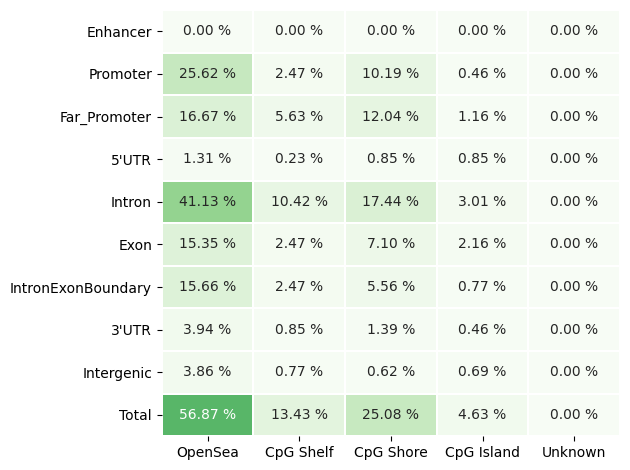

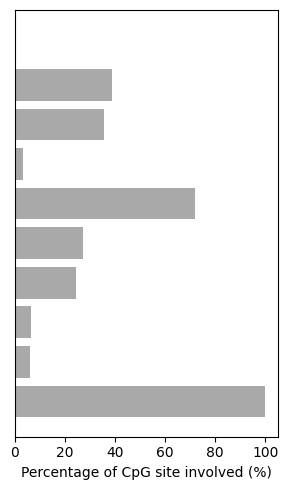

In [52]:
import seaborn as sns
from matplotlib import pyplot as plt
outdir = f"/BiO/Research/Project2/Infectomics_COVID-19_Host/Resources/Infectomics_COVID-19_RNA/Backup/Copy_from_Shrimp/COVID19Infected/Results/10_methyl/{visit}/{direction}"

ax = sns.heatmap(data = table_heatmap_perc[list(filter(lambda x : x != "Total", table_heatmap_perc.columns))], annot = True, fmt = ".2f", cmap = "Greens", cbar = False, vmin=0, vmax = 100, linewidths = 0.1)
for t in ax.texts:
    t.set_text(t.get_text() + " %")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "annotation_heatmap.png"), dpi=600)
plt.show()
plt.close()

plt.figure(figsize=(3, 5))
plt.barh(width = table_heatmap_perc["Total"], y = table_heatmap_perc.index, color = "darkgray")
plt.gca().invert_yaxis()
plt.yticks([])
plt.xlabel("Percentage of CpG site involved (%)")
plt.tight_layout()
plt.savefig(os.path.join(outdir, "annotation_distibution.png"), dpi=600)
plt.show()
plt.close()

In [53]:
df_tot

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Intron,False,chr1_1110694_1110694
chr1_1123255_1123255,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Intron,False,chr1_1758260_1758260
...,...,...,...,...,...,...,...,...
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,NPDC1,Intron,False,chr9_137044952_137044952
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,FUT7,Far_Promoter,False,chr9_137044952_137044952
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,NPDC1,Promoter,False,chr9_137044952_137044952


In [54]:
df_promot = df_tot[df_tot["Gene_Attrib"].isin(["Promoter", "Far_Promoter"])]

In [55]:
df_enst_hypo = pd.read_csv(enst_hypo, sep="\t")

In [56]:
df_enst_hypo

,ensembl_transcript_id_version,ensembl_gene_id,external_transcript_name,external_gene_name
0,ENST00000612368.1,ENSG00000273828,NaN,NaN
1,ENST00000651935.1,ENSG00000273828,NaN,NaN
2,ENST00000420902.1,ENSG00000235111,NaN,NaN
3,ENST00000623955.1,ENSG00000279354,NaN,NaN
4,ENST00000443970.1,ENSG00000228165,NaN,NaN
...,...,...,...,...
138,ENST00000456450.1,ENSG00000237370,NaN,NaN
139,ENST00000362058.2,ENSG00000291072,CROCCP2-202,CROCCP2
140,ENST00000639399.1,ENSG00000283773,NaN,NaN
141,ENST00000495523.1,ENSG00000116138,DNAJC16-209,DNAJC16


In [57]:
print("\n".join(df_enst_hypo.loc[:, "external_gene_name"].dropna().unique()))

ATP11A
PSMF1
RPL3P3
RPL18AP2
PBX3-DT
KRT18P22
Metazoa_SRP
QRFP
TAF4
KRT18P59
TXNDC11-AS1
RPL23AP1
DMWD
RPL17P46
SLC38A10
ZDHHC20P2
PTMAP1
IGHJ6
MGAT1
LRRC14
RN7SL684P
RPS12P26
ATXN7
KPNA2P1
AMDHD2
RN7SL750P
PRADX
RNU1-32P
CDH3
GAPDHP40
UBE2V1P6
KIF19BP
PMM2
CCDC26
LACTB2-AS1
SNHG10
SEPTIN9
SH3BP2
AK3P2
RNU7-52P
LINC01485
BANP
PEF1-AS1
RPL36AP30
LYPD5
LINC00910
SCYGR3
LINC02611
CHIT1
CROCCP2
DNAJC16


In [58]:
print('\n'.join(list(filter(lambda x : not x.startswith("ENST"), df_promot["Gene_Symbol"].unique()))))

C1orf159
NADK
CEP104
C1orf174
CHD5
ZBTB48
H6PD
KAZN
DNAJC16
EPHA2
EPHA2-AS1
MST1P2
CROCCP2
ATP13A2
UBR4
EIF4G3
RAP1GAP
MAN1C1
SH3BGRL3
ZDHHC18
WDTC1
MAP3K6
COL16A1
ADGRB2
PHC2
MIR3605
TFAP2E-AS1
TFAP2E
STK40
MACF1
PABPC4
PABPC4-AS1
PPIEL
COL9A2
LOC107984951
BTBD19
DYNLT4
TUT4
LRP8
SGIP1
CLCA2
LINC01356
NGF-AS1
SETDB1
RAB13
RPS27
ATP8B2
SHE
ARHGEF2
HDGF
OR10J4
SH2D1B
NIBAN1
INAVA
CHIT1
LINC01353
IL10
LAMB3
TRAF3IP3
CAPN2
TP53BP2
OBSCN
SIPA1L2
IRF2BP2
PFKP
PITRM1-AS1
LINC02660
LOC105376384
LOC107984220
GJD4
LINC02623
LOC102724323
BICC1
PCBD1
SFTPA1
ANXA11
LRIT1
RGR
PTEN
ENTPD1
ENTPD1-AS1
HOGA1
NKX2-3
LINC01475
CFAP46
DEAF1
EPS8L2
TMEM80
PNPLA2
CRACR2B
CTSD
IFITM10
SAAL1
KIAA1549L
ATG13
ZNF408
ARHGAP1
OOSP4B
VPS37C
NXF1
LGALS12
MARK2
OTUB1
LOC114841035
FKBP2
PLCB3
CAPN1
CDC42EP2
LOC105369344
RBM4B
GRK2
ALDH3B2
CTTN
LAMTOR1
TOMT
WNT11
SMCO4
LOC101929295
LOC100129203
BTG4
LAYN
SLC37A4
DPAGT1
C2CD2L
TRIM29
SORL1
TMEM218
SRPRA
FOXRED1
ST3GAL4
LOC101929473
LOC574538
LOC105369592
IQSEC3
CACNA1C

In [59]:
df_tot

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Intron,False,chr1_1110694_1110694
chr1_1123255_1123255,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Intron,False,chr1_1758260_1758260
...,...,...,...,...,...,...,...,...
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,NPDC1,Intron,False,chr9_137044952_137044952
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,FUT7,Far_Promoter,False,chr9_137044952_137044952
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,NPDC1,Promoter,False,chr9_137044952_137044952


In [60]:
df_tot_uniq = df_tot.drop_duplicates(subset = ["chr", "start"])

In [61]:
df_tot_uniq 

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
chr1_1123255_1123255,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
chr1_1779948_1779948,chr1,1779948,1779948,CpG Shore,NADK,Far_Promoter,False,chr1_1779948_1779948
chr1_1842884_1842884,chr1,1842884,1842884,OpenSea,GNB1,Intron,False,chr1_1842884_1842884
...,...,...,...,...,...,...,...,...
chr9_136917877_136917877,chr9,136917877,136917877,OpenSea,TRAF2,Intron,False,chr9_136917877_136917877
chr9_136917900_136917900,chr9,136917900,136917900,OpenSea,TRAF2,Intron,False,chr9_136917900_136917900
chr9_136917906_136917906,chr9,136917906,136917906,OpenSea,TRAF2,Intron,False,chr9_136917906_136917906


In [62]:
df_tot_uniq = df_tot_uniq.sort_values(by = ["chr", "start"])

In [63]:
df_tot_uniq

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_109792397_109792397,chr1,109792397,109792397,OpenSea,None,Intergenic,False,chr1_109792397_109792397
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
chr1_1123255_1123255,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
chr1_112850378_112850378,chr1,112850378,112850378,CpG Shore,LINC01356,Promoter,False,chr1_112850378_112850378
chr1_115283021_115283021,chr1,115283021,115283021,OpenSea,ENST00000649888.1,Intron,False,chr1_115283021_115283021
...,...,...,...,...,...,...,...,...
chr9_88391884_88391884,chr9,88391884,88391884,CpG Shelf,ENST00000622148.1,Promoter,False,chr9_88391884_88391884
chr9_93292477_93292477,chr9,93292477,93292477,CpG Shore,WNK2,Promoter,False,chr9_93292477_93292477
chr9_98831869_98831869,chr9,98831869,98831869,OpenSea,GALNT12,IntronExonBoundary,False,chr9_98831869_98831869


In [64]:
df_tot_uniq.dtypes

chr            object
start          object
end            object
CpGs           object
Gene_Symbol    object
Gene_Attrib    object
Is_Enhancer      bool
PosName        object
dtype: object

In [65]:
df_tot_uniq["start"] = df_tot_uniq["start"].astype(int)

In [66]:
df_tot_uniq = df_tot_uniq.sort_values(by = ["chr", "start"])

In [67]:
df_tot_uniq

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
chr1_1123255_1123255,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
chr1_1779948_1779948,chr1,1779948,1779948,CpG Shore,NADK,Far_Promoter,False,chr1_1779948_1779948
chr1_1842884_1842884,chr1,1842884,1842884,OpenSea,GNB1,Intron,False,chr1_1842884_1842884
...,...,...,...,...,...,...,...,...
chr9_136917877_136917877,chr9,136917877,136917877,OpenSea,TRAF2,Intron,False,chr9_136917877_136917877
chr9_136917900_136917900,chr9,136917900,136917900,OpenSea,TRAF2,Intron,False,chr9_136917900_136917900
chr9_136917906_136917906,chr9,136917906,136917906,OpenSea,TRAF2,Intron,False,chr9_136917906_136917906


In [69]:
list_chr

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype=object)

In [70]:
from joblib import Parallel, delayed

with Parallel(n_jobs = len(list_chr)) as parallel:
    list_results_per_chr = parallel(delayed(get_neighbor_methyl)(df_tot_uniq[df_tot_uniq["chr"] == chrname]) for chrname in list_chr)

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

In [71]:
df_tot_uniq.iloc[0, :]["PosName"]

'chr1_1110694_1110694'

In [72]:
def get_neighbor_methyl(table_part):
    list_neighbor = [[table_part.iloc[0, :]["PosName"]]]
    for _, row in table_part.iloc[1:, :].iterrows():
        bef_pos = int(list_neighbor[-1][-1].split('_')[-1])
        row_pos = int(row["start"])
        if abs(row_pos - bef_pos) <= 100:
            list_neighbor[-1].append(row["PosName"])
        else:
            list_neighbor.append([row["PosName"]])
    return list_neighbor

In [73]:
from joblib import Parallel, delayed

with Parallel(n_jobs = len(list_chr)) as parallel:
    list_results_per_chr = parallel(delayed(get_neighbor_methyl)(df_tot_uniq[df_tot_uniq["chr"] == chrname]) for chrname in list_chr)

In [74]:
from itertools import chain
list_neighbors = list(chain(list_results_per_chr))

In [75]:
list(filter(lambda x : len(x) > 1, list_neighbors))

[[['chr1_1110694_1110694'],
  ['chr1_1123255_1123255'],
  ['chr1_1758260_1758260'],
  ['chr1_1779948_1779948'],
  ['chr1_1842884_1842884'],
  ['chr1_2085406_2085406'],
  ['chr1_2150988_2150988'],
  ['chr1_2175051_2175051', 'chr1_2175061_2175061'],
  ['chr1_2344933_2344933'],
  ['chr1_2404772_2404772'],
  ['chr1_3590604_3590604'],
  ['chr1_3816903_3816903'],
  ['chr1_3903099_3903099'],
  ['chr1_3903251_3903251', 'chr1_3903255_3903255'],
  ['chr1_5975613_5975613', 'chr1_5975628_5975628', 'chr1_5975668_5975668'],
  ['chr1_6184526_6184526', 'chr1_6184580_6184580', 'chr1_6184603_6184603'],
  ['chr1_6582026_6582026'],
  ['chr1_6582152_6582152'],
  ['chr1_8213239_8213239',
   'chr1_8213277_8213277',
   'chr1_8213293_8213293',
   'chr1_8213295_8213295',
   'chr1_8213300_8213300',
   'chr1_8213310_8213310',
   'chr1_8213322_8213322'],
  ['chr1_9233489_9233489'],
  ['chr1_11842891_11842891'],
  ['chr1_12181017_12181017'],
  ['chr1_13705512_13705512'],
  ['chr1_14929641_14929641'],
  ['chr1_14944

In [76]:
from itertools import chain
list_neighbors = list(chain(*list_results_per_chr))

In [77]:
list(filter(lambda x : len(x) > 1, list_neighbors))

[['chr1_2175051_2175051', 'chr1_2175061_2175061'],
 ['chr1_3903251_3903251', 'chr1_3903255_3903255'],
 ['chr1_5975613_5975613', 'chr1_5975628_5975628', 'chr1_5975668_5975668'],
 ['chr1_6184526_6184526', 'chr1_6184580_6184580', 'chr1_6184603_6184603'],
 ['chr1_8213239_8213239',
  'chr1_8213277_8213277',
  'chr1_8213293_8213293',
  'chr1_8213295_8213295',
  'chr1_8213300_8213300',
  'chr1_8213310_8213310',
  'chr1_8213322_8213322'],
 ['chr1_14944853_14944853', 'chr1_14944860_14944860'],
 ['chr1_16157152_16157152', 'chr1_16157164_16157164'],
 ['chr1_19081624_19081624',
  'chr1_19081659_19081659',
  'chr1_19081748_19081748'],
 ['chr1_33328208_33328208', 'chr1_33328237_33328237'],
 ['chr1_44412097_44412097', 'chr1_44412111_44412111'],
 ['chr1_94629666_94629666', 'chr1_94629673_94629673'],
 ['chr1_115283021_115283021', 'chr1_115283039_115283039'],
 ['chr1_150927836_150927836', 'chr1_150927847_150927847'],
 ['chr1_156754446_156754446', 'chr1_156754501_156754501'],
 ['chr1_162412140_162412140'

In [78]:
len(list(chain(*list(filter(lambda x : len(x) > 1, list_neighbors)))))

567

In [79]:
df_tot_uniq.shape

(1296, 8)

In [80]:
count_neighbor_size = list(map(lambda x : len(x), list_neighbors))

<BarContainer object of 728 artists>

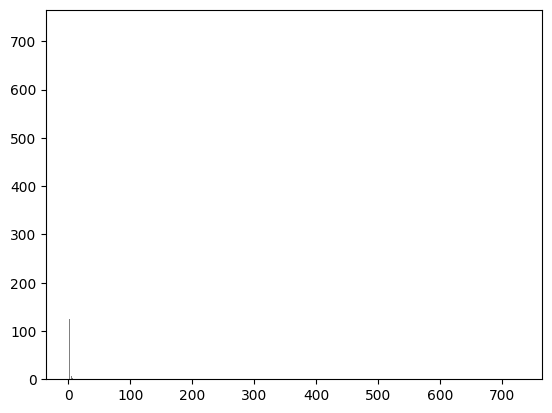

In [81]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.bar(range(1, max(count_neighbor_size.values())), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.values())))), color = "gray")

In [82]:
count_neighbor_size

Counter({1: 729, 2: 125, 3: 57, 7: 2, 4: 18, 11: 1, 5: 7, 8: 1, 6: 1})

<BarContainer object of 10 artists>

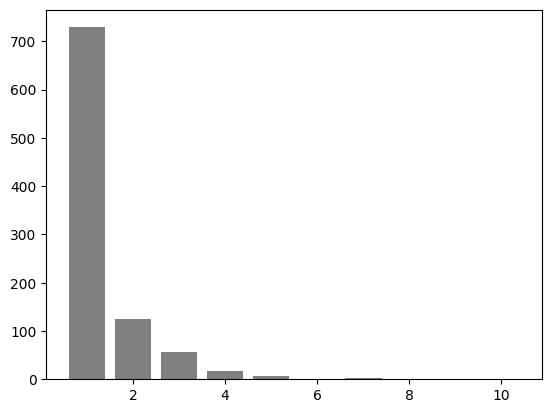

In [83]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.bar(range(1, max(count_neighbor_size.keys())), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())))), color = "gray")

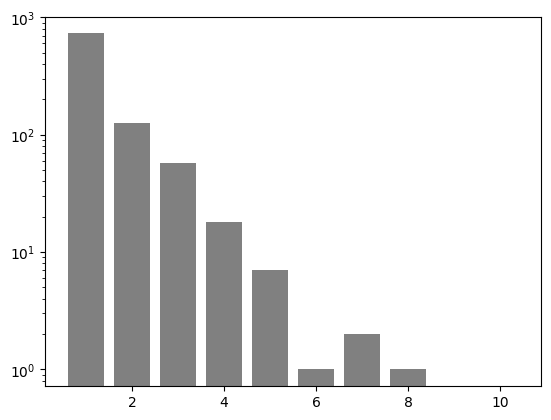

In [84]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.bar(range(1, max(count_neighbor_size.keys())), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())))), color = "gray")
plt.yscale("log")

In [85]:
count_neighbor_size

Counter({1: 729, 2: 125, 3: 57, 7: 2, 4: 18, 11: 1, 5: 7, 8: 1, 6: 1})

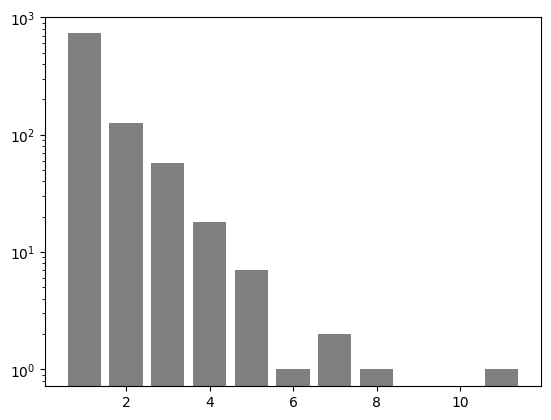

In [86]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray")
plt.yscale("log")

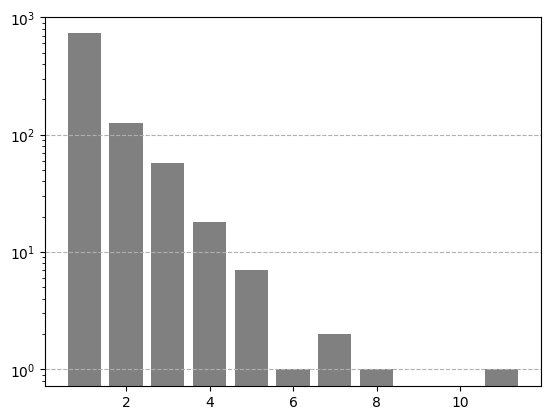

In [87]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray")
plt.yscale("log")
plt.grid(axis = "y", linestyle = "--")

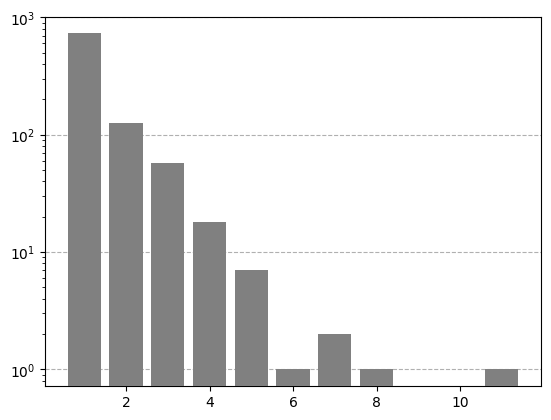

In [88]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray", zorder = 3)
plt.yscale("log")
plt.grid(axis = "y", linestyle = "--", zorder = 1)

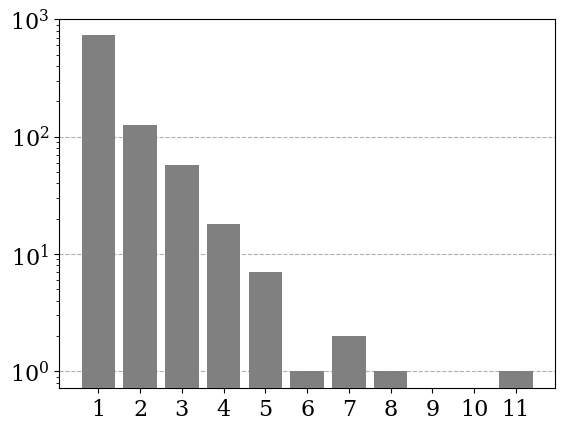

In [89]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray", zorder = 3)
plt.xticks(range(1, max(count_neighbor_size.keys())+1))
plt.yscale("log")
plt.grid(axis = "y", linestyle = "--", zorder = 1)

Text(0.5, 0, 'Size of Neighbor CpG Biomarkers')

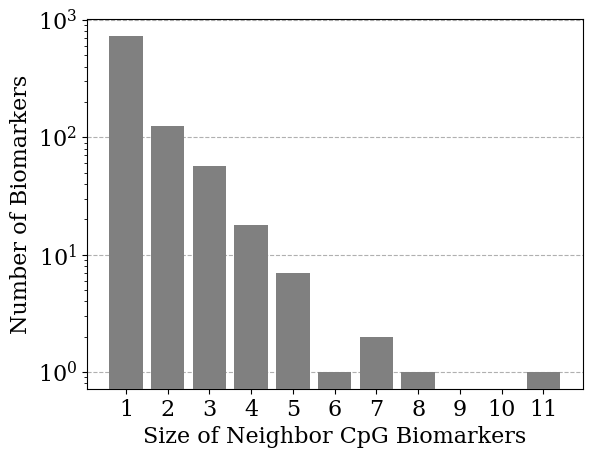

In [90]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray", zorder = 3)
plt.xticks(range(1, max(count_neighbor_size.keys())+1))
plt.yscale("log")
plt.grid(axis = "y", linestyle = "--", zorder = 1)
plt.ylabel("Number of Biomarkers")
plt.xlabel("Size of Neighbor CpG Biomarkers")

In [91]:
list(chain(*list(filter(lambda x : len(x) > 1, list_neighbors))))

['chr1_2175051_2175051',
 'chr1_2175061_2175061',
 'chr1_3903251_3903251',
 'chr1_3903255_3903255',
 'chr1_5975613_5975613',
 'chr1_5975628_5975628',
 'chr1_5975668_5975668',
 'chr1_6184526_6184526',
 'chr1_6184580_6184580',
 'chr1_6184603_6184603',
 'chr1_8213239_8213239',
 'chr1_8213277_8213277',
 'chr1_8213293_8213293',
 'chr1_8213295_8213295',
 'chr1_8213300_8213300',
 'chr1_8213310_8213310',
 'chr1_8213322_8213322',
 'chr1_14944853_14944853',
 'chr1_14944860_14944860',
 'chr1_16157152_16157152',
 'chr1_16157164_16157164',
 'chr1_19081624_19081624',
 'chr1_19081659_19081659',
 'chr1_19081748_19081748',
 'chr1_33328208_33328208',
 'chr1_33328237_33328237',
 'chr1_44412097_44412097',
 'chr1_44412111_44412111',
 'chr1_94629666_94629666',
 'chr1_94629673_94629673',
 'chr1_115283021_115283021',
 'chr1_115283039_115283039',
 'chr1_150927836_150927836',
 'chr1_150927847_150927847',
 'chr1_156754446_156754446',
 'chr1_156754501_156754501',
 'chr1_162412140_162412140',
 'chr1_162412189_1624

Text(0.5, 0, 'Size of Neighbor CpG Biomarkers')

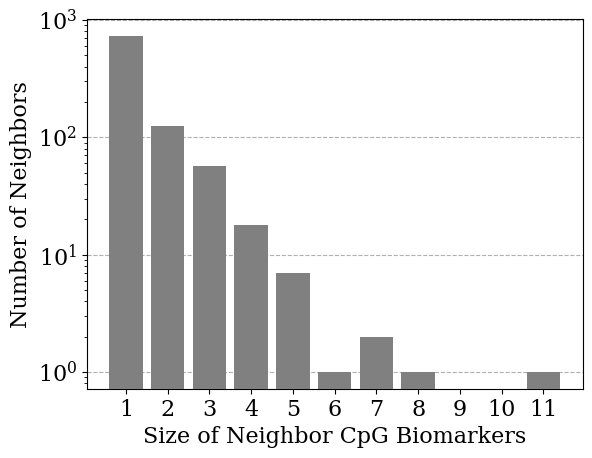

In [92]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray", zorder = 3)
plt.xticks(range(1, max(count_neighbor_size.keys())+1))
plt.yscale("log")
plt.grid(axis = "y", linestyle = "--", zorder = 1)
plt.ylabel("Number of Neighbors")
plt.xlabel("Size of Neighbor CpG Biomarkers")

Text(0.5, 0, 'Size of Neighbor CpG Biomarkers')

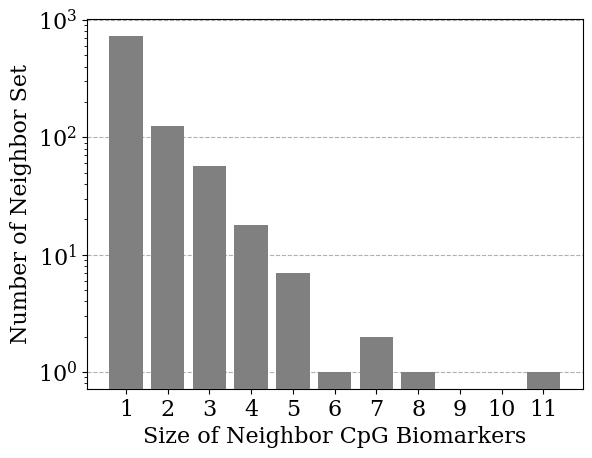

In [93]:
from collections import Counter
neighbor_size = list(map(lambda x : len(x), list_neighbors))
count_neighbor_size = Counter(neighbor_size)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.bar(range(1, max(count_neighbor_size.keys())+1), list(map(lambda x : count_neighbor_size[x], range(1, max(count_neighbor_size.keys())+1))), color = "gray", zorder = 3)
plt.xticks(range(1, max(count_neighbor_size.keys())+1))
plt.yscale("log")
plt.grid(axis = "y", linestyle = "--", zorder = 1)
plt.ylabel("Number of Neighbor Set")
plt.xlabel("Size of Neighbor CpG Biomarkers")

In [94]:
list(filter(lambda x : len(x) > 10, list_neighbors))

[['chr11_94545373_94545373',
  'chr11_94545381_94545381',
  'chr11_94545403_94545403',
  'chr11_94545416_94545416',
  'chr11_94545423_94545423',
  'chr11_94545430_94545430',
  'chr11_94545438_94545438',
  'chr11_94545444_94545444',
  'chr11_94545464_94545464',
  'chr11_94545475_94545475',
  'chr11_94545491_94545491']]

In [95]:
df_tot

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Far_Promoter,False,chr1_1110694_1110694
chr1_1110694_1110694,chr1,1110694,1110694,CpG Island,C1orf159,Intron,False,chr1_1110694_1110694
chr1_1123255_1123255,chr1,1123255,1123255,OpenSea,None,Intergenic,False,chr1_1123255_1123255
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Promoter,False,chr1_1758260_1758260
chr1_1758260_1758260,chr1,1758260,1758260,CpG Shelf,NADK,Intron,False,chr1_1758260_1758260
...,...,...,...,...,...,...,...,...
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,NPDC1,Intron,False,chr9_137044952_137044952
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,FUT7,Far_Promoter,False,chr9_137044952_137044952
chr9_137044952_137044952,chr9,137044952,137044952,CpG Shore,NPDC1,Promoter,False,chr9_137044952_137044952


In [96]:
df_tot.loc["chr11_94545373_94545373"]

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr11_94545373_94545373,chr11,94545373,94545373,CpG Island,PIWIL4,Exon,False,chr11_94545373_94545373
chr11_94545373_94545373,chr11,94545373,94545373,CpG Island,PIWIL4-AS1,Exon,False,chr11_94545373_94545373
chr11_94545373_94545373,chr11,94545373,94545373,CpG Island,PIWIL4,Intron,False,chr11_94545373_94545373
chr11_94545373_94545373,chr11,94545373,94545373,CpG Island,PIWIL4,5'UTR,False,chr11_94545373_94545373
chr11_94545373_94545373,chr11,94545373,94545373,CpG Island,FUT4,Exon,False,chr11_94545373_94545373


In [97]:
list(filter(lambda x : len(x) > 2, list_neighbors))

[['chr1_5975613_5975613', 'chr1_5975628_5975628', 'chr1_5975668_5975668'],
 ['chr1_6184526_6184526', 'chr1_6184580_6184580', 'chr1_6184603_6184603'],
 ['chr1_8213239_8213239',
  'chr1_8213277_8213277',
  'chr1_8213293_8213293',
  'chr1_8213295_8213295',
  'chr1_8213300_8213300',
  'chr1_8213310_8213310',
  'chr1_8213322_8213322'],
 ['chr1_19081624_19081624',
  'chr1_19081659_19081659',
  'chr1_19081748_19081748'],
 ['chr1_224457049_224457049',
  'chr1_224457059_224457059',
  'chr1_224457090_224457090'],
 ['chr1_236399771_236399771',
  'chr1_236399791_236399791',
  'chr1_236399794_236399794'],
 ['chr10_1089651_1089651', 'chr10_1089661_1089661', 'chr10_1089668_1089668'],
 ['chr10_42871370_42871370',
  'chr10_42871397_42871397',
  'chr10_42871452_42871452'],
 ['chr10_45453703_45453703',
  'chr10_45453768_45453768',
  'chr10_45453802_45453802',
  'chr10_45453841_45453841'],
 ['chr10_80158934_80158934',
  'chr10_80158979_80158979',
  'chr10_80159005_80159005'],
 ['chr11_61162717_61162717',


In [98]:
df_tot.loc[list(chain(*list(filter(lambda x : len(x) > 1, list_neighbors))))]

,chr,start,end,CpGs,Gene_Symbol,Gene_Attrib,Is_Enhancer,PosName
PosName,,,,,,,,
chr1_2175051_2175051,chr1,2175051,2175051,CpG Shelf,PRKCZ,Intron,False,chr1_2175051_2175051
chr1_2175051_2175051,chr1,2175051,2175051,CpG Shelf,PRKCZ,IntronExonBoundary,False,chr1_2175051_2175051
chr1_2175061_2175061,chr1,2175061,2175061,CpG Shelf,PRKCZ,Intron,False,chr1_2175061_2175061
chr1_2175061_2175061,chr1,2175061,2175061,CpG Shelf,PRKCZ,IntronExonBoundary,False,chr1_2175061_2175061
chr1_3903251_3903251,chr1,3903251,3903251,CpG Shore,LINC01134,Intron,False,chr1_3903251_3903251
...,...,...,...,...,...,...,...,...
chr9_136917877_136917877,chr9,136917877,136917877,OpenSea,TRAF2,Far_Promoter,False,chr9_136917877_136917877
chr9_136917900_136917900,chr9,136917900,136917900,OpenSea,TRAF2,Intron,False,chr9_136917900_136917900
chr9_136917900_136917900,chr9,136917900,136917900,OpenSea,TRAF2,Far_Promoter,False,chr9_136917900_136917900


In [99]:
print('\n'.join(df_tot.loc[list(chain(*list(filter(lambda x : len(x) > 1, list_neighbors))))]["Gene_Symbol"].unique()))

PRKCZ
LINC01134
C1orf174
NPHP4
CHD5
RPL22
LINC01714
KAZN
EPHA2-AS1
EPHA2
UBR4
ENST00000628643.2
PHC2
ENST00000630909.2
ENST00000627130.1
RNF220
LOC107984951
SLC44A3-AS1
ENST00000649888.1
NGF-AS1
SETDB1
HDGF
PRCC
SH2D1B
TOR3A
RGS2
LOC105371665
LOC105371664
INAVA
KIF21B
None
ENST00000455363.2
CAPN2
CNIH3
EDARADD
WDR37
LOC105376384
IL15RA
LINC02623
LOC102724323
ANXA11
CCNJ
ENTPD1-AS1
HOGA1
PI4K2A
ITPRIP
ENST00000662565.1
PTPRE
ENST00000433110.1
ENST00000420845.1
ATG13
ENST00000533964.1
PTPRJ
VPS37C
NXF1
STX5
POLA2
CDC42EP2
LOC105369344
RBM4B
GRK2
LOC107984360
ENST00000531511.1
PIWIL4
PIWIL4-AS1
FUT4
SLC37A4
CHD4
ETV6
BICD1
ENST00000556606.1
ANAPC7
NCOR2
ENST00000541343.1
SFSWAP
POLE
CRYL1
MIR4499
FOXO1
TUBGCP3
ATP11A
ENST00000614170.1
TMCO3
ENST00000619338.1
LOC101929718
DGLUCY
SNORA11B
SNHG10
ENST00000663212.1
LOC112268122
ENST00000490023.1
MARK3
ENST00000567396.1
DENND4A
ENST00000567680.1
RAB11A
SALRNA2
KLHL25
MIR1276
SEMA4B
ENST00000492017.3
ENST00000621088.1
RAB11FIP3
MSRB1
AMDHD2
ENS

In [100]:
print('\n'.join(df_tot.loc[list(chain(*list(filter(lambda x : len(x) > 2, list_neighbors))))]["Gene_Symbol"].unique()))

NPHP4
CHD5
RPL22
LINC01714
UBR4
CNIH3
EDARADD
WDR37
LINC02623
LOC102724323
ANXA11
VPS37C
NXF1
STX5
LOC107984360
ENST00000531511.1
PIWIL4
PIWIL4-AS1
FUT4
ETV6
NCOR2
POLE
TUBGCP3
ATP11A
ENST00000614170.1
LOC101929718
SNHG10
ENST00000663212.1
LOC112268122
ENST00000567396.1
DENND4A
ENST00000567680.1
RAB11A
KLHL25
MIR1276
SEMA4B
ENST00000492017.3
MSRB1
AMDHD2
ENST00000565570.1
KCTD5
ENST00000567942.1
ENST00000564919.1
LOC100130283
PMM2
SETD1A
KIAA0513
None
ANKFY1
ENST00000572564.1
CYB5D2
SENP3-EIF4A1
SENP3
TNFSF12-TNFSF13
ENST00000610459.1
TNFSF13
SKAP1
MIR1203
PRPSAP1
SEPTIN9
ENST00000590595.1
CBX4
GNG7
ENST00000623521.1
NFIC
MLLT1
ACTN4
KLF11
ENST00000607181.1
DTNB
ECRG4
HDAC4
LOC107984104
SUMO1P1
TAF4
TRPM2
ITPR1
MCM2
MCF2L2
XXYLT1
ENST00000664895.1
PCGF3
MAEA
LIAS
ENST00000513652.1
LOC401127
ACSL1
NSUN2
ROPN1L
ERGIC1
ENST00000518675.1
LINC01485
ENST00000522571.1
DOK3
DUSP22
GMDS
LOC101928047
LOC101928004
RAB44
DSE
ENST00000476099.1
CALHM6
ENST00000402024.2
TNFAIP3
ADAP1
COX19
MAD1L1
FOX

In [101]:
print('\n'.join(df_tot.loc[list(chain(*list(filter(lambda x : len(x) > 3, list_neighbors))))]["Gene_Symbol"].unique()))

LINC01714
LOC102724323
NXF1
STX5
PIWIL4
PIWIL4-AS1
FUT4
ETV6
POLE
TUBGCP3
ATP11A
ENST00000614170.1
KLHL25
MIR1276
SEMA4B
ENST00000492017.3
None
ANKFY1
ENST00000572564.1
CYB5D2
PRPSAP1
CBX4
ENST00000623521.1
NFIC
MLLT1
KLF11
ENST00000607181.1
HDAC4
SUMO1P1
TAF4
TRPM2
MCF2L2
MAEA
TNFAIP3
ADAP1
COX19
TRIB1
AGO2
CCIN
SH2D3C
TRAF2


In [102]:
print('\n'.join(df_tot.loc[list(chain(*list(filter(lambda x : len(x) > 4, list_neighbors))))]["Gene_Symbol"].unique()))

LINC01714
PIWIL4
PIWIL4-AS1
FUT4
POLE
TUBGCP3
ANKFY1
ENST00000572564.1
CYB5D2
PRPSAP1
ENST00000623521.1
NFIC
MLLT1
SUMO1P1
TNFAIP3
SH2D3C
TRAF2
